In [2]:
pip install plotly

  Using cached plotly-5.0.0-py2.py3-none-any.whl (19.1 MB)
  Using cached tenacity-7.0.0-py2.py3-none-any.whl (23 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style('white')

pd.set_option('precision', 5)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)
pd.set_option('mode.chained_assignment', None)

%load_ext autoreload
%autoreload 2

import cv2

import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
gt = pd.read_csv('/mnt/sdb/yokoo/fbisc/input/public_ground_truth.csv')

In [5]:
tmp = gt[gt['reference_id'].notna()]


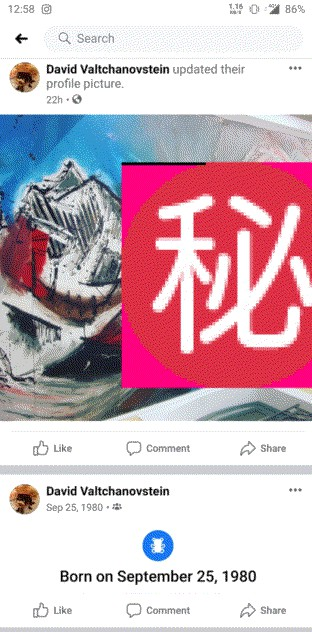

In [17]:
i = 2013
qid, rid = tmp.iloc[i]

qimg = cv2.imread(f'/mnt/sdb/yokoo/fbisc/input/query_images/{qid}.jpg')[:,:,::-1]
px.imshow(qimg)


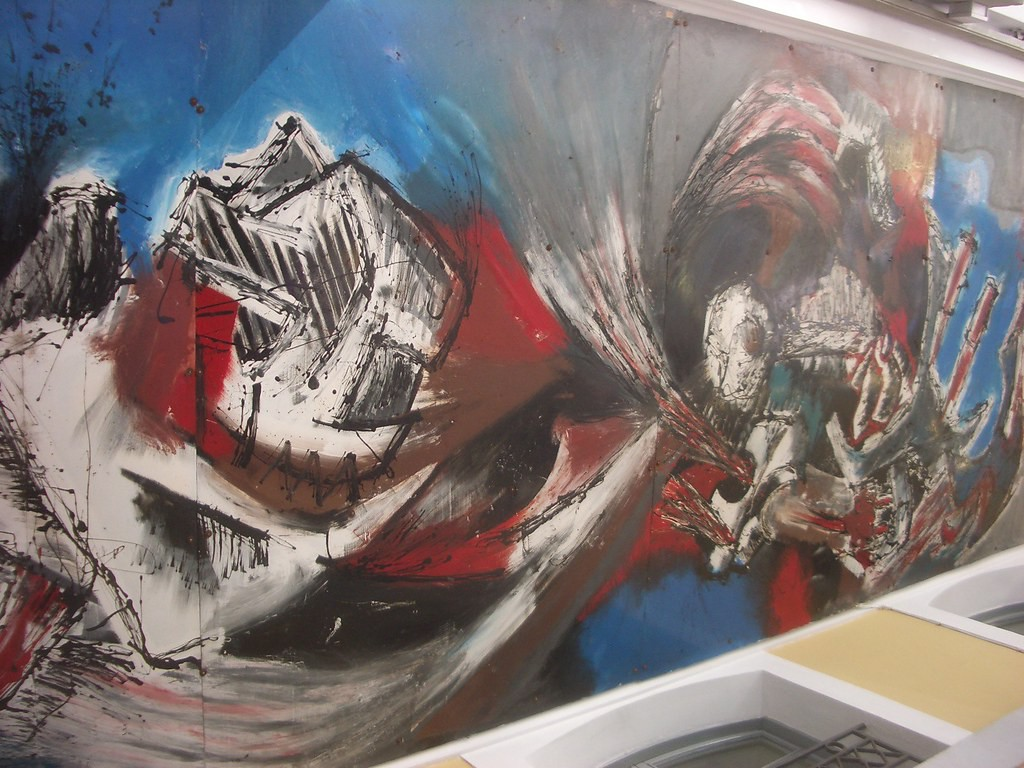

In [18]:
# if isinstance(rid, str):
rimg = cv2.imread(f'/mnt/sdb/yokoo/fbisc/input/reference_images/{rid}.jpg')[:,:,::-1]
px.imshow(rimg)

In [19]:
import augly.image as imaugs

In [143]:
from augly.image import (
    EncodingQuality,
    OverlayOntoScreenshot,
    RandomBlur,
    RandomBrightness,
    RandomPixelization,
    Saturation,
    ShufflePixels,
    OneOf,
)

from augly.image.functional import overlay_emoji, overlay_text
from augly.image.transforms import BaseTransform
from augly.utils.constants import FONT_PATH, SMILEY_EMOJI_DIR
from augly.utils import pathmgr
from typing import Any, Dict, List, Optional
import random
import os

class RandomOverlayText(BaseTransform):
    def __init__(
        self,
        font_file: str = FONT_PATH,
        opacity: float = 1.0,
        p: float = 1.0,
    ):
        super().__init__(p)
        self.font_file = font_file
        self.opacity = opacity

    def apply_transform(
        self, image: Image.Image, metadata: Optional[List[Dict[str, Any]]] = None
    ) -> Image.Image:
        return overlay_text(
            image,
            text=[random.randrange(1, 100000) for _ in range(5)],
            font_file=self.font_file,
            font_size=random.uniform(0.1, 0.3),
            opacity=self.opacity,
            color=[random.randrange(0, 256) for _ in range(3)],
            x_pos=random.uniform(0.0, 0.5),
            y_pos=random.uniform(0.0, 0.5),
            metadata=metadata,
        )

class RandomEmojiOverlay(BaseTransform):
    def __init__(
        self,
        emoji_directory: str = SMILEY_EMOJI_DIR,
        opacity: float = 1.0,
        p: float = 1.0,
    ):
        super().__init__(p)
        self.emoji_directory = emoji_directory
        self.emoji_paths = pathmgr.ls(emoji_directory)
        self.opacity = opacity

    def apply_transform(
        self, image: Image.Image, metadata: Optional[List[Dict[str, Any]]] = None
    ) -> Image.Image:
        emoji_path = random.choice(self.emoji_paths)
        return overlay_emoji(
            image,
            emoji_path=os.path.join(self.emoji_directory, emoji_path),
            opacity=self.opacity,
            emoji_size=random.uniform(0.1, 0.3),
            x_pos=random.uniform(0.0, 1.0),
            y_pos=random.uniform(0.0, 1.0),
            metadata=metadata,
        )

In [25]:
import torchvision.transforms as transforms
from PIL import Image

In [69]:
img = Image.open(f'/mnt/sdb/yokoo/fbisc/input/reference_images/{rid}.jpg')

In [170]:
from types import SimpleNamespace
args = SimpleNamespace()
args.input_size= 320

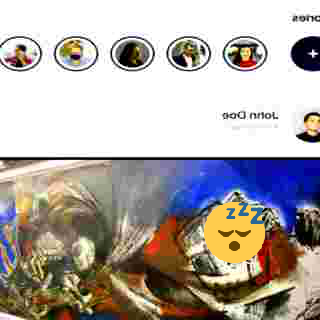

In [208]:
overlay1 = OverlayOntoScreenshot()
overlay2 = OverlayOntoScreenshot(template_filepath=overlay1.template_filepath.replace('web', 'mobile'))

transforms.Compose([
    OneOf([overlay1, overlay2], p=1.0),
    transforms.RandomResizedCrop(args.input_size, scale=(0.2, 1.)),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    Saturation(factor=2.0, p=0.2),
    RandomBrightness(min_factor=0.5, max_factor=1.5, p=0.2),
    RandomPixelization(p=0.2),
    ShufflePixels(factor=0.1, p=0.2),
    OneOf([EncodingQuality(quality=q) for q in [10, 20, 30, 50]], p=0.5),
    transforms.RandomGrayscale(p=0.2),
    RandomBlur(p=0.2),
    transforms.RandomPerspective(p=0.2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    RandomOverlayText(p=0.2),
    RandomEmojiOverlay(p=0.2),
    transforms.ToTensor(),
    transforms.RandomErasing(value='random', p=0.2),
    transforms.ToPILImage(),
])(img)

In [186]:
%debug

> /home/shuhei.yokoo/anaconda3/envs/fbisc/lib/python3.7/site-packages/torchvision/transforms/functional.py(335)normalize()
    333     if std.ndim == 1:
    334         std = std.view(-1, 1, 1)
--> 335     tensor.sub_(mean).div_(std)
    336     return tensor
    337 

ipdb> u
> /home/shuhei.yokoo/anaconda3/envs/fbisc/lib/python3.7/site-packages/torchvision/transforms/transforms.py(221)forward()
    219             Tensor: Normalized Tensor image.
    220         """
--> 221         return F.normalize(tensor, self.mean, self.std, self.inplace)
    222 
    223     def __repr__(self):

ipdb> u
> /home/shuhei.yokoo/anaconda3/envs/fbisc/lib/python3.7/site-packages/torch/nn/modules/module.py(1051)_call_impl()
   1049         if not (self._backward_hooks or self._forward_hooks or self._forward_pre_hooks or _global_backward_hooks
   1050                 or _global_forward_hooks or _global_forward_pre_hooks):
-> 1051             return forward_call(*input, **kwargs)
   1052         # Do not c

torchvision.transforms.transforms.ColorJitter